## Basic analysis

In [3]:
#Libraries and main variables initialized
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import urllib.request, json
import os
import re
import nglview as nv
from funcs import get_files_from_git
from funcs import view_nucl


import matplotlib.pyplot as plt

import MDAnalysis.analysis.pca as pca
import MDAnalysis.analysis.encore as encore

from seq_tools.plot4seq import plot_prof4seq
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import seq1
from seq_tools.hist_ss import get_hist_ss_in_aln_for_shade
import numpy as np
import xvg_plot as xvg
import xpm_plot as xpm

#Reloading funcs if changed
from importlib import reload 
import funcs,config
reload(funcs)
reload(config)


%matplotlib inline
%load_ext rpy2.ipython

from config import movtitle
from IPython.display import Markdown, display
from config import folder,descr,pname,scuser
display(Markdown(descr))
print("Folder set to: ",folder)
print("Project name: ",pname)
print("User set to:",scuser)




# MD simulations of H3-H4, tails truncated
- AMBER14SB force field
- 50 mM NaCl
- box 2nm


Folder set to:  h3-h4_tm
Project name:  h3-h4_tm
User set to: shaytan_1609


## Let's preview

In [ ]:
view_nucl('GMX_system/prot_ref.pdb', 'big_data/prot_md.xtc')


## Movie

In [3]:
#args 1 1 will trigger generation of images for movie in tmp/dat
!rm tmp/dat/*
!vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/prot_ref.pdb big_data/prot_md.xtc "$movtitle" 0 1 1 1
!rm big_data/movie.*
!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie.mov
#!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie.wmv

/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 40 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA 
Info) Free system memory: 53GB (84%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1050 Ti  6 SM_6.1 @ 1.39 GHz, 3.9GB RAM, KTO, AE2, ZCP
Info) Detected 1 available TachyonL/OptiX

In [72]:
#Make a smooth movie
!vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/prot_ref.pdb big_data/prot_md.xtc "$movtitle, smoothed" 20 1 1 1
!rm big_data/movie_sm20.*
!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_sm20.mov
#!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_sm20.wmv

/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 40 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA 
Info) Free system memory: 51GB (80%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1050 Ti  6 SM_6.1 @ 1.39 GHz, 3.9GB RAM, KTO, AE2, ZCP
Info) Detected 1 available TachyonL/OptiX

In [5]:
%%HTML
<video width="320" height="240" controls>
  <source src="big_data/movie.mov" type="video/mp4">
</video>
<video width="320" height="240" controls>
  <source src="big_data/movie_sm20.mov" type="video/mp4">
</video>

## RMSD, radius of gyration

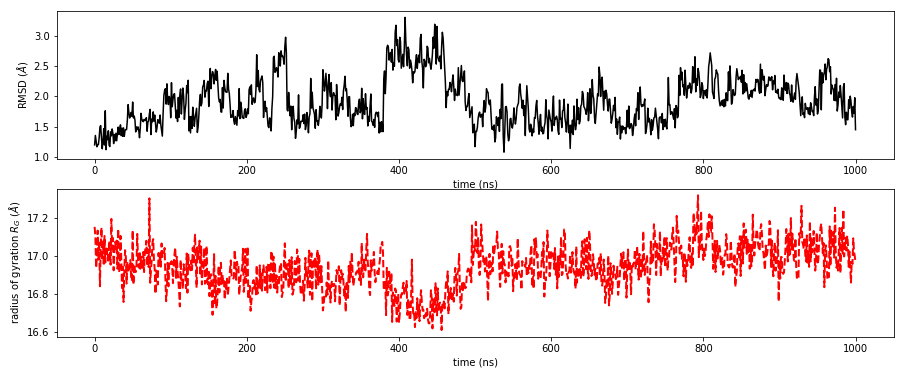

In [6]:
#MDAnalysis
trj=mda.Universe('GMX_system/prot_ref.pdb', 'big_data/prot_md.xtc')
ref = mda.Universe('GMX_system/prot_ref.pdb')
R = mda.analysis.rms.RMSD(trj, ref, select="protein and backbone",filename="big_data/rmsd.dat")
R.run()

rmsd = R.rmsd.T   # transpose makes it easier for plotting

time = list(map(lambda x: x/1000,rmsd[1]))

prot = trj.select_atoms("protein")
Rgyr=[]
for ts in trj.trajectory[::1]:
   Rgyr.append((trj.trajectory.time, prot.radius_of_gyration()))
Rgyr = np.array(Rgyr)

plt.figure(figsize=(15,6))
ax = plt.subplot(211)
ax.plot(time, rmsd[2], 'k-',  label="backbone")
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"RMSD ($\AA$)")

ax2 = plt.subplot(212)
ax2.plot(time, Rgyr[:,1], 'r--', lw=2, label=r"$R_G$")
ax2.set_xlabel("time (ns)")
ax2.set_ylabel(r"radius of gyration $R_G$ ($\AA$)")

plt.draw()

## RMSF along the sequence

In [7]:
# Let's extract the sequence
u=mda.Universe('GMX_system/prot_ref.pdb')
#prot = nuclMD.select_atoms("protein")
#u.select_atoms('segid A and protein').segments.resnames[0]
#list(u.select_atoms('segid A and protein').segments.resnames[0])
chainA_seq=seq1(''.join(list(u.select_atoms('segid A and protein').segments.resnames[0])))
chainB_seq=seq1(''.join(list(u.select_atoms('segid B and protein').segments.resnames[0])))
print(chainA_seq)
#Let's get features
msaH3=MultipleSeqAlignment([SeqRecord(Seq(chainA_seq[1:]),id='H3',name='H3')])
featuresH3=get_hist_ss_in_aln_for_shade(msaH3,below=True)
msaH4=MultipleSeqAlignment([SeqRecord(Seq(chainB_seq[1:]),id='H4',name='H4')])
featuresH4=get_hist_ss_in_aln_for_shade(msaH4,below=True)


XGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA
SingleLetterAlphabet() alignment with 2 rows and 135 columns
ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPG...ERA H3
-------------------------------------------G...ERA Query
Type detected= H3
SingleLetterAlphabet() alignment with 2 rows and 102 columns
SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVK...FGG H4
----------------------RDNIQGITKPAIRRLARRGGVK...FGG Query
Type detected= H4


In [8]:
# Let's generate RMSF for every amino acid Calpha
from MDAnalysis.analysis.rms import RMSF
trj=mda.Universe('GMX_system/prot_ref.pdb', 'big_data/prot_md.xtc')
calphasH3 = trj.select_atoms("segid A and name CA")
rmsferH3 = RMSF(calphasH3, verbose=True).run()
calphasH4 = trj.select_atoms("segid B and name CA")
rmsferH4 = RMSF(calphasH4, verbose=True).run()

Step  1001/1001 [100.0%]
Step  1001/1001 [100.0%]


### Texshade way

In [9]:

plot_prof4seq('big_data/h3-rmsf',rmsferH3.rmsf,msaH3,featuresH3,axis='RMSF, A')
plot_prof4seq('big_data/h4-rmsf',rmsferH4.rmsf,msaH4,featuresH4,axis='RMSF, A')

Chosen splitting parameters
2 20
Launcning Latex:
pdflatex --file-line-error --synctex=1 -output-directory=/tmp --save-size=10000  /tmp/align.tex > /dev/null
mv /tmp/align.pdf /tmp/tempshade.pdf
Converting PDF to PNG
convert -density 150 /tmp/tempshade.pdf -trim -bordercolor White -border 0.000%x0% /tmp/tempprofseq.png
Chosen splitting parameters
2 20
Launcning Latex:
pdflatex --file-line-error --synctex=1 -output-directory=/tmp --save-size=10000  /tmp/align.tex > /dev/null
mv /tmp/align.pdf /tmp/tempshade.pdf
Converting PDF to PNG
convert -density 150 /tmp/tempshade.pdf -trim -bordercolor White -border 0.000%x0% /tmp/tempprofseq.png


In [10]:
%%HTML
H3 C-alpha RMSF
<img src="big_data/h3-rmsf.png" alt="Plot" >
H4 C-alpha RMSF
<img src="big_data/h4-rmsf.png" alt="Plot" >

### Matplotlib way

## C $\alpha$ fluctuations
We need to make plot as above but for side chains. The charactristic now is RMSF not of position but of RMSD taken for the atoms of the side chain.

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
Step  1001/1001 [100.0%]


SingleLetterAlphabet() alignment with 2 rows and 135 columns
ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPG...ERA H3
------------------------------------------XG...ERA Query
Type detected= H3


## Chain A CA RMSF

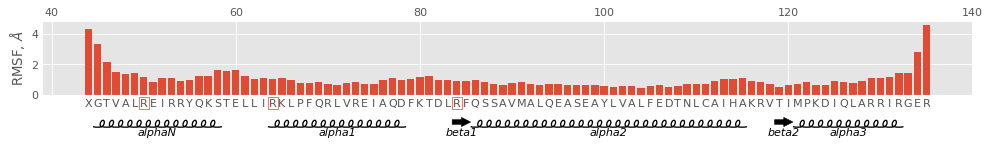

Step  1001/1001 [100.0%]


SingleLetterAlphabet() alignment with 2 rows and 102 columns
SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVK...FGG H4
---------------------XRDNIQGITKPAIRRLARRGGVK...FGG Query
Type detected= H4


## Chain B CA RMSF

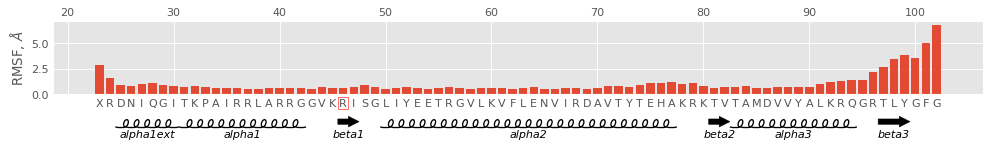

In [32]:
from MDAnalysis.analysis.rms import RMSD
from seq_tools.mpl_shade import plot_on_seq
trj=mda.Universe('GMX_system/prot_ref.pdb', 'big_data/prot_md.xtc')
ref = mda.Universe('GMX_system/prot_ref.pdb')

segIDs=trj.segments.segids
for segID in segIDs:
    calphas = trj.select_atoms("segid %s and name CA"%segID)
    rmsfer = RMSF(calphas, verbose=True).run()
    resids=trj.select_atoms('segid %s and protein and  name CA'%segID).residues.resids
    chain_seq=seq1(''.join(list(trj.select_atoms('segid %s and protein'%segID).residues.resnames)))
    msa=MultipleSeqAlignment([SeqRecord(Seq(chain_seq),id=segID,name=segID)])
    features=get_hist_ss_in_aln_for_shade(msa,below=True)
    with plt.style.context(('ggplot')):
        display(Markdown('## Chain %s CA RMSF'%segID))
        plot_on_seq(rmsfer.rmsf,msa[0].seq,features=features,resids=resids,
                    y_axis_label=r'RMSF, $\AA$',figsize=(15,2),dpi=80)
   

## Fluctuation heat plots C$\alpha$
We need to make 2D heatplots showing a) C-alphas position deviation from X-ray, b) side chain RMSD, along the sequence in time.

SingleLetterAlphabet() alignment with 2 rows and 135 columns
ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPG...ERA H3
------------------------------------------XG...ERA Query
Type detected= H3


## Chain A CA RMSD

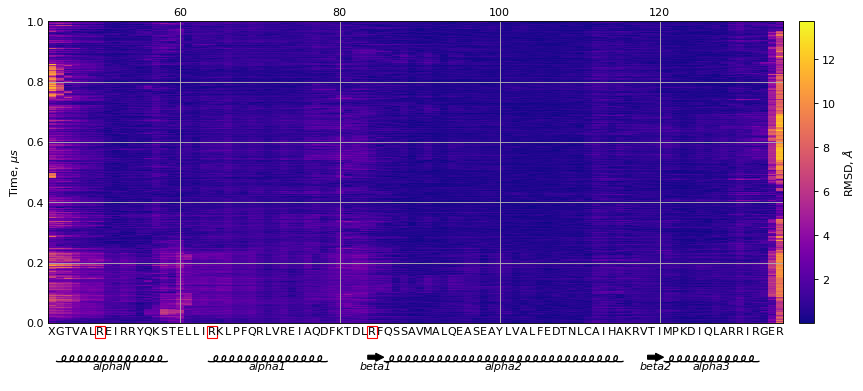

SingleLetterAlphabet() alignment with 2 rows and 102 columns
SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVK...FGG H4
---------------------XRDNIQGITKPAIRRLARRGGVK...FGG Query
Type detected= H4


## Chain B CA RMSD

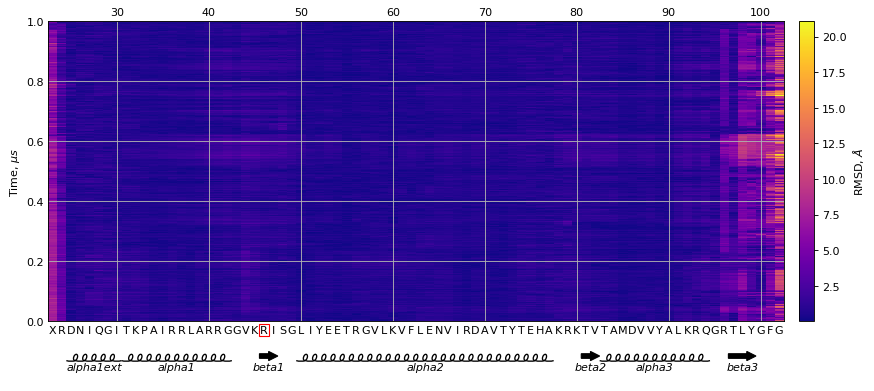

In [24]:
from MDAnalysis.analysis.rms import RMSD
from seq_tools.mpl_shade import heatplot_on_seq
trj=mda.Universe('GMX_system/prot_ref.pdb', 'big_data/prot_md.xtc')
ref = mda.Universe('GMX_system/prot_ref.pdb')

segIDs=trj.segments.segids
for segID in segIDs:
    resids=trj.select_atoms('segid %s and protein and  name CA'%segID).residues.resids
    groupselections=["segid %s and protein and resid %d  and  name CA"%(segID,resid) for resid in resids]
    chain_fluc=RMSD(trj, ref,
           select="segid %s and protein and  name CA"%segID,             # superimpose on whole backbone of the whole protein
           groupselections=groupselections,                                    # NMP
           filename="big_data/rmsd_all_resids_%s.dat"%segID)
    chain_fluc.run()
    
    
    chain_seq=seq1(''.join(list(trj.select_atoms('segid %s and protein'%segID).residues.resnames)))
    msa=MultipleSeqAlignment([SeqRecord(Seq(chain_seq),id=segID,name=segID)])
    features=get_hist_ss_in_aln_for_shade(msa,below=True)
    display(Markdown('## Chain %s CA RMSD'%segID))
    fig1=heatplot_on_seq(chain_fluc.rmsd[:,3:],msa[0].seq,filename='big_data/RMSD_vs_T_ch%s.png'%segID,
                      figsize=(10,5),dpi=80,features=features,resids=resids,cmap='plasma',
                      y_axis_values=chain_fluc.rmsd[:,0]/1000, y_axis_label=r"Time, $\mu s$",colorbar_label=r'RMSD, $\AA$')




## Fluctuation heat plots sidechains
We need to make 2D heatplots showing a) C-alphas position deviation from X-ray, b) side chain RMSD, along the sequence in time.

SingleLetterAlphabet() alignment with 2 rows and 135 columns
ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPG...ERA H3
------------------------------------------XG...ERA Query
Type detected= H3


## Chain A sidechain RMSF

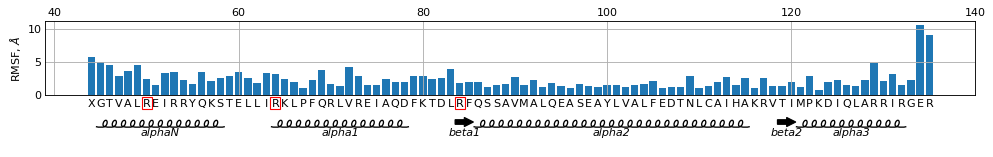

## Chain A sidechain RMSD

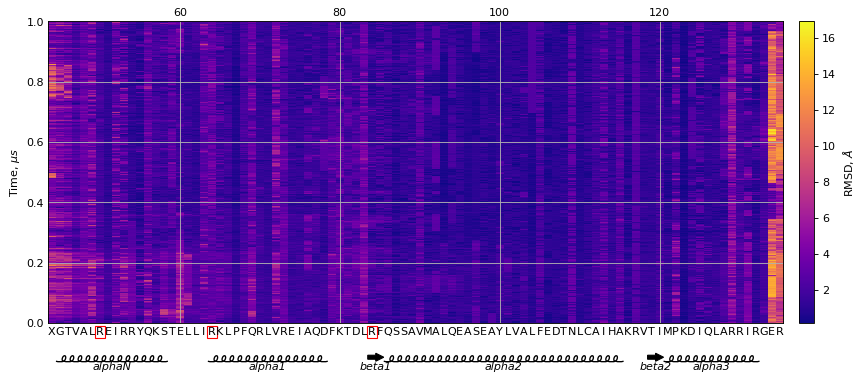

SingleLetterAlphabet() alignment with 2 rows and 102 columns
SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVK...FGG H4
---------------------XRDNIQGITKPAIRRLARRGGVK...FGG Query
Type detected= H4


## Chain B sidechain RMSF

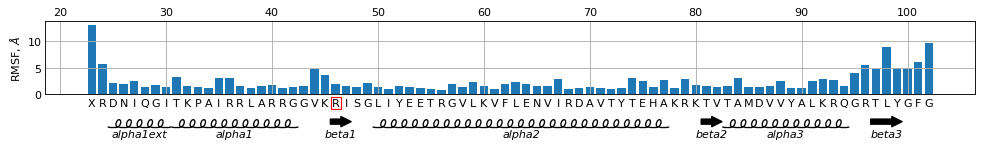

## Chain B sidechain RMSD

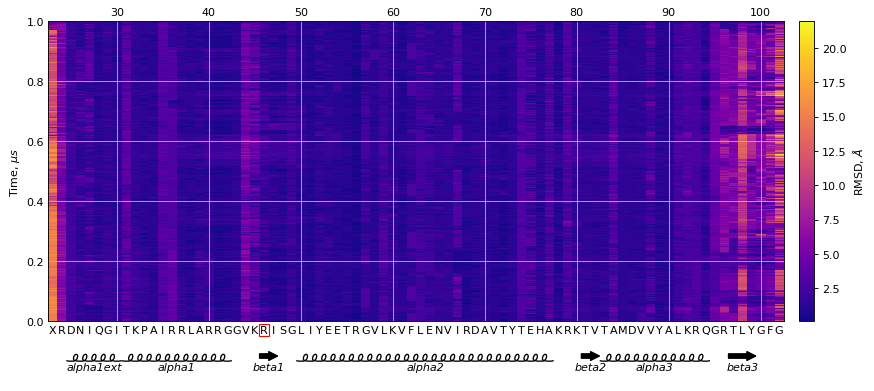

In [34]:
from MDAnalysis.analysis.rms import RMSD
from seq_tools.mpl_shade import heatplot_on_seq
trj=mda.Universe('GMX_system/prot_ref.pdb', 'big_data/prot_md.xtc')
ref = mda.Universe('GMX_system/prot_ref.pdb')

segIDs=trj.segments.segids
for segID in segIDs:
    resids=trj.select_atoms('segid %s and protein and  name CA'%segID).residues.resids
    groupselections=["segid %s and protein and resid %d  and  not backbone"%(segID,resid) for resid in resids]
    chain_fluc=RMSD(trj, ref,
           select="segid %s and protein and  name CA"%segID,             # superimpose on whole backbone of the whole protein
           groupselections=groupselections,                                    # NMP
           filename="big_data/rmsd_all_resids_%s.dat"%segID)
    chain_fluc.run()
    
    
    chain_seq=seq1(''.join(list(trj.select_atoms('segid %s and protein'%segID).residues.resnames)))
    msa=MultipleSeqAlignment([SeqRecord(Seq(chain_seq),id=segID,name=segID)])
    features=get_hist_ss_in_aln_for_shade(msa,below=True)

    rmsf=np.power(np.power(chain_fluc.rmsd.T[3:], 2).mean(1),0.5)
    display(Markdown('## Chain %s sidechain RMSF'%segID))
    plot_on_seq(rmsf,msa[0].seq,features=features,resids=resids,
                y_axis_label=r'RMSF, $\AA$',figsize=(15,2),dpi=80)
    
    display(Markdown('## Chain %s sidechain RMSD'%segID))
    fig1=heatplot_on_seq(chain_fluc.rmsd[:,3:],msa[0].seq,filename='big_data/RMSD_vs_T_ch%s.png'%segID,
                      figsize=(10,5),dpi=80,features=features,resids=resids,cmap='plasma',
                      y_axis_values=chain_fluc.rmsd[:,0]/1000, y_axis_label=r"Time, $\mu s$",colorbar_label=r'RMSD, $\AA$')




## Cluster analysis

Gromacs way

http://manual.gromacs.org/documentation/current/onlinehelp/gmx-rms.html

http://manual.gromacs.org/documentation/current/onlinehelp/gmx-cluster.html

In [11]:
%%bash
#gromacs implementation 
gmx rms -dt 1 -tu ns -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -f2 big_data/prot_md.xtc -m big_data/rmsd-matrix.xpm -o big_data/rmsd.xvg <<!
1
1
!

Selected 1: 'Protein'
Selected 1: 'Protein'


                       :-) GROMACS - gmx rms, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS deve

In [12]:
from importlib import reload 
import xpm_plot
reload(xpm_plot)

<module 'xpm_plot' from '/home/_shared/_projects/gmx_template/xpm_plot.py'>

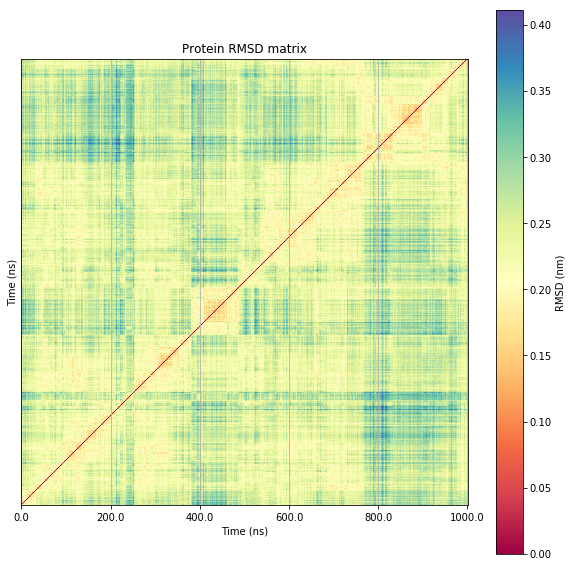

In [13]:
metadata, data = xpm.parse_xpm('big_data/rmsd-matrix.xpm')
xpm.plot_data(data, metadata)


In [14]:
%%bash
#gromacs implementation 
gmx cluster -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -dm big_data/rmsd-matrix.xpm -dt 1000 \
-dist big_data/rms-distribution.xvg -o big_data/clusters.xpm -sz big_data/cluster-sizes.xvg \
-tr big_data/cluster-transitions.xpm -ntr big_data/cluster-transitions.xvg -g big_data/cluster.log \
-clid big_data/cluster-id-over-time.xvg -cl big_data/clusters.pdb -cutoff 0.25 -method gromos <<!
1
1
!
#pymol clusters.pdb 
#split_states clusters
#delete clusters 
#dss
#show cartoon


Selected 1: 'Protein'
Selected 1: 'Protein'


                     :-) GROMACS - gmx cluster, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [15]:
view_nucl('big_data/clusters.pdb')


NGLWidget(count=8)

### Plot clustering XVG files

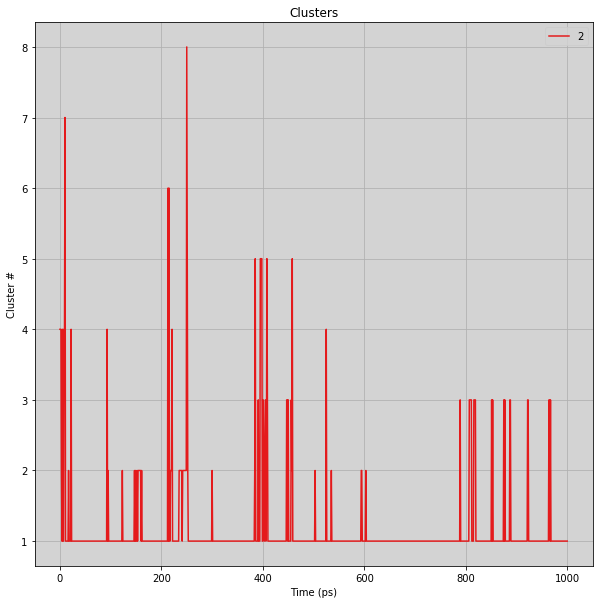

In [16]:
metadata, data = xvg.parse_xvg('big_data/cluster-id-over-time.xvg', 'all')
xvg.plot_data(data, metadata)


## PCA

## PCA analysis

http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-covar.html

In [17]:
%%bash 
#gromacs implementation
#Choose a group for the least squares fit (4 - backbone)
#Choose a group for the covariance analysis (4 - backbone)

#gmx covar -s GMX_run/7_prod.tpr -f big_data/h3-h4.xtc -o big_data/eigenval.xvg -v big_data/eigenvect.trr -xpma big_data/covara.xpm <<!
#4
#4
#!
gmx covar -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -o big_data/eigenval.xvg -v big_data/eigenvect.trr -xpma big_data/covara.xpm -av big_data/average.pdb -l big_data/covar.log <<!
7
7
!


Choose a group for the least squares fit
Selected 7: 'MainChain+H'

Choose a group for the covariance analysis
Selected 7: 'MainChain+H'


                      :-) GROMACS - gmx covar, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [18]:
#This is now done in step 1_prepare
#%%bash --out out --err err
## Let's make backbone file
#gmx trjconv -f GMX_system/init_solv_ions.pdb -s GMX_run/7_prod.tpr -o big_data/bb_xray.pdb << !
#4
#!
#gmx trjconv -f GMX_system/init_solv_ions.pdb -s GMX_run/7_prod.tpr -o big_data/bb-h_xray.pdb << !
#7
#!

In [19]:
from importlib import reload 
import xvg_plot
import xpm_plot


reload(xvg_plot)
reload(xpm_plot)

<module 'xpm_plot' from '/home/_shared/_projects/gmx_template/xpm_plot.py'>

No handles with labels found to put in legend.


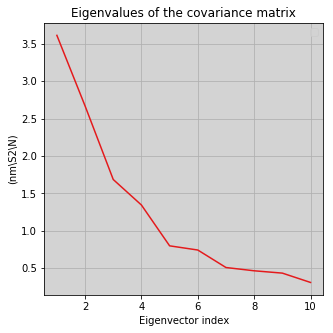

In [20]:
metadata, data = xvg.parse_xvg('big_data/eigenval.xvg', 'all')
data=np.array(data)
data=data[:,0:10]
xvg.plot_data(data, metadata,figsize=(5,5))


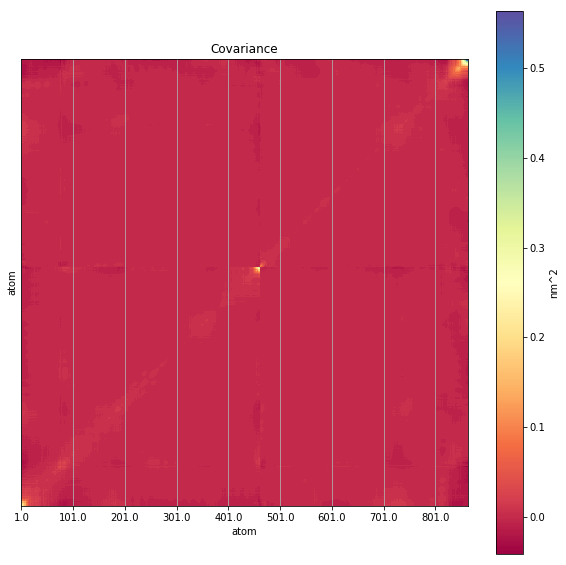

In [21]:
metadata, data = xpm.parse_xpm('big_data/covara.xpm')
xpm.plot_data(data, metadata)


### Let's filter our trajectory along one or several eigenvectors
http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-anaeig.html

In [22]:
%%bash --err err 
gmx anaeig -v big_data/eigenvect.trr -dt 10000 -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -first 1 -last 1 -filt big_data/filtered.xtc <<!
7
7
!
# We need to center it
gmx trjconv -f big_data/filtered.xtc -s GMX_system/bb-h_ref.pdb -o big_data/filtered.xtc -fit rot+trans << !
1
1
!


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Select group for least squares fit
Selected 1: 'Protein'
Select group for output
Selected 1: 'Protein'


In [23]:
view_nucl('GMX_system/bb-h_ref.pdb','big_data/filtered.xtc')

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=101)

#### Let's make movie

In [24]:
!rm tmp/dat/*
!vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/bb-h_ref.pdb big_data/filtered.xtc "$movtitle, filtered 1 eigenvector" 0 1 1 1
!rm big_data/movie_pca_filt.*
!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_pca_filt.mov
#!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_pca_filt.wmv

/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 40 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA 
Info) Free system memory: 53GB (84%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1050 Ti  6 SM_6.1 @ 1.39 GHz, 3.9GB RAM, KTO, AE2, ZCP
Info) Detected 1 available TachyonL/OptiX

In [26]:
%%HTML
<video width="320" height="240" controls>
  <source src="big_data/movie_pca_filt.mov" type="video/mp4">
</video>

### Let's make interpolations for 6 PCA vectors
http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-anaeig.html

In [27]:
%%bash 
#--out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -first 1 -last 6 -nframes 50  -extr big_data/interp.xtc<<!
7
7
!

for i in `seq 1 6`; do
echo $i
gmx trjconv -f big_data/interp$i.xtc -s GMX_system/bb-h_ref.pdb -o big_data/interp$i.xtc -fit rot+trans << !
1
1
!
done


Select the index group that was used for the least squares fit in g_covar
Selected 7: 'MainChain+H'

Select an index group of 863 elements that corresponds to the eigenvectors
Selected 7: 'MainChain+H'

1

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Select group for least squares fit
Selected 1: 'Protein'
Select group for output
Selected 1: 'Protein'
2

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Select group for least squares fit
Selected 1: 'Protein'
Select group for output
Selected 1: 'Protein'
3

 

                      :-) GROMACS - gmx anaeig, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [28]:
view_nucl('GMX_system/bb-h_ref.pdb','big_data/interp1.xtc',gui=True)

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=50)

In [2]:
#!vmd -e VMD_scripts/view_nucl.tcl -args GMX_system/bb-h_ref.pdb big_data/interp1.xtc "MD, PCA eigenv. 1 interp" 0 0 0 0


/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 40 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA 
Info) Free system memory: 52GB (82%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1050 Ti  6 SM_6.1 @ 1.39 GHz, 3.9GB RAM, KTO, AE2, ZCP
Info) OpenGL renderer: GeForce GTX 1050 T

In [44]:
%%writefile tmp/render.sh
#!/bin/bash
for p in `seq 1 6`; do 
rm tmp/dat/* ;
vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/bb-h_ref.pdb big_data/interp$p.xtc "$1, PCA eigenv. $p interp." 0 1 1 0

echo "Let's add back frames" 
for i in `seq 2 49`; do
f=`expr 100 - $i`
echo $f
cp tmp/dat/$i.dat.tga tmp/dat/$f.dat.tga
done 

# Let's generate videos
rm big_data/movie_pca$p.* ;
ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_pca$p.mov 
done 

#This concats a movie with its reverse
#ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  -filter_complex "[0:v]reverse,fifo[r];[0:v][r] concat=n=2:v=1 [v]" -map "[v]" big_data/movie_pca1.mov



Overwriting tmp/render.sh


In [45]:
!chmod u+x tmp/render.sh
!tmp/render.sh "$movtitle"

/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 40 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA 
Info) Free system memory: 52GB (83%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1050 Ti  6 SM_6.1 @ 1.39 GHz, 3.9GB RAM, KTO, AE2, ZCP
Info) Detected 1 available TachyonL/OptiX

In [46]:
%%HTML
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca1.mov" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca2.mov" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca3.mov" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca4.mov" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca5.mov" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca6.mov" type="video/mp4">
</video>

## Let's plot projections

In [33]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -first 1 -last 2 -2d big_data/2d_pca12.xvg<<!
7
7
!

No handles with labels found to put in legend.


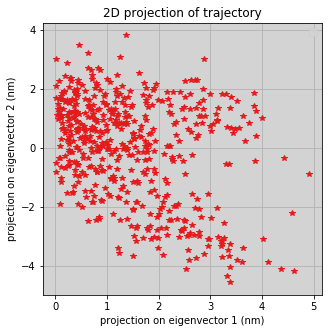

In [34]:
metadata, data = xvg.parse_xvg('big_data/2d_pca12.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')

In [35]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -first 2 -last 3 -2d big_data/2d_pca23.xvg<<!
7
7
!

No handles with labels found to put in legend.


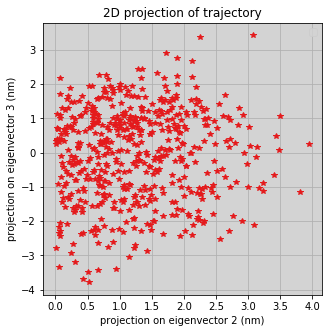

In [36]:
metadata, data = xvg.parse_xvg('big_data/2d_pca23.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')

In [37]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -first 3 -last 4 -2d big_data/2d_pca34.xvg<<!
7
7
!

No handles with labels found to put in legend.


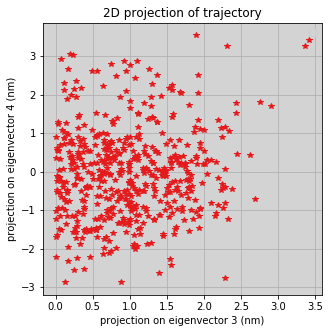

In [38]:
metadata, data = xvg.parse_xvg('big_data/2d_pca34.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')

In [39]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -f big_data/prot_md.xtc -first 4 -last 5 -2d big_data/2d_pca45.xvg<<!
7
7
!

No handles with labels found to put in legend.


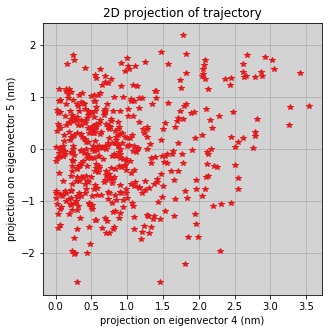

In [40]:
metadata, data = xvg.parse_xvg('big_data/2d_pca45.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')